In [9]:
from utils import *
# importlib.reload(utils)
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
base_url = "https://www.football-data.co.uk/mmz4281/{}/E0.csv"
season = "1415"

In [3]:
df = get_match_data(base_url.format(season))
ws = get_winstreak(df)

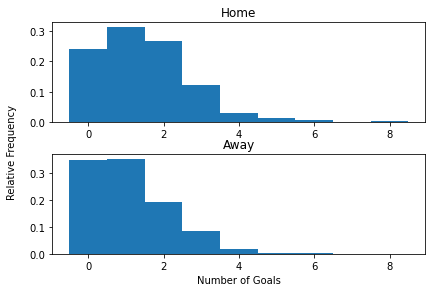

In [40]:
### Histogram of home and away goals
fig, axs = plt.subplots(2,1)
fig.text(0, .5, 'Relative Frequency', ha='center', va='center', rotation='vertical')
plt.xlabel("Number of Goals")
fig.tight_layout()
bins = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]
axs[0].hist(df["FTHG"], density=True,bins=bins)
axs[1].hist(df["FTAG"], density=True,bins=bins)
axs[0].set_title("Home")
axs[1].set_title("Away")

plt.savefig("figures/poisson_frequency.jpeg", dpi=300)

In [5]:
### Gradient descent / NO MOMENTUM

### Parameter matrix rows: home off, home def, away off, away def
params = np.ones((4,20))

num_itrs = 20000
lr = 0.0001

teams_ind = {
    "Arsenal": 0,
    "Aston Villa": 1,
    "Burnley": 2,
    "Chelsea": 3,
    "Crystal Palace": 4,
    "Everton": 5,
    "Hull": 6,
    "Leicester": 7,
    "Liverpool": 8,
    "Man City": 9,
    "Man United": 10,
    "Newcastle": 11,
    "QPR": 12,
    "Southampton": 13,
    "Stoke": 14,
    "Sunderland": 15,
    "Swansea": 16,
    "Tottenham": 17,
    "West Brom": 18,
    "West Ham": 19
    }

for i in tqdm(range(num_itrs)):
    batch = df.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]

        # update home team params
        params[0,home_index] += lr * (home_goal / params[0,home_index] - params[3,away_index])
        params[1,home_index] += lr * (away_goal / params[1,home_index] - params[2,away_index])

        # update away team params
        params[2,away_index] += lr * (away_goal / params[2,away_index] - params[1,home_index])
        params[3,away_index] += lr * (home_goal / params[3,away_index] - params[0,home_index])


100%|██████████| 20000/20000 [00:37<00:00, 531.25it/s]


In [12]:
### Gradient descent / MOMENTUM

### Parameter matrix rows: home off, home def, away off, away def
team_params = np.ones((4,20))
streak_param = 1

num_itrs = 20000
lr = 0.0001

teams_ind = {
    "Arsenal": 0,
    "Aston Villa": 1,
    "Burnley": 2,
    "Chelsea": 3,
    "Crystal Palace": 4,
    "Everton": 5,
    "Hull": 6,
    "Leicester": 7,
    "Liverpool": 8,
    "Man City": 9,
    "Man United": 10,
    "Newcastle": 11,
    "QPR": 12,
    "Southampton": 13,
    "Stoke": 14,
    "Sunderland": 15,
    "Swansea": 16,
    "Tottenham": 17,
    "West Brom": 18,
    "West Ham": 19
    }

for i in tqdm(range(num_itrs)):
    batch = df.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]
        week = row["MatchWeek"]
        home_streak = ws.loc[week,row["HomeTeam"]]
        away_streak = ws.loc[week,row["AwayTeam"]]

        # update home team params
        team_params[0,home_index] += lr * (home_goal / team_params[0,home_index] - team_params[3,away_index] * (streak_param ** home_streak))
        team_params[1,home_index] += lr * (away_goal / team_params[1,home_index]// - team_params[2,away_index] * (streak_param ** away_streak))
        if home_streak != 0:
            streak_param += lr * (home_goal * home_streak / streak_param - home_streak * team_params[0,home_index] * team_params[3,away_index] * (streak_param ** (home_streak - 1)))

        # update away team params
        team_params[2,away_index] += lr * (away_goal / team_params[2,away_index] - team_params[1,home_index] * (streak_param ** away_streak))
        team_params[3,away_index] += lr * (home_goal / team_params[3,away_index] - team_params[0,home_index] * (streak_param ** home_streak))
        if away_streak != 0:
            streak_param += lr * (away_goal * away_streak / streak_param - away_streak * team_params[2,away_index] * team_params[1,home_index] * (streak_param ** (away_streak - 1)))


100%|██████████| 10000/10000 [00:33<00:00, 299.59it/s]
